In [1]:
import networkx as nx
import numpy as np
from matplotlib.pyplot import *
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import scipy
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import datetime
#from minepy import MINE

In [2]:
from preprocessing_net import get_cyclic_net
from mutual_info import *
from nrmse_calc import nrmse, nrmse_n
from r_to_python import *

In [3]:
#imports
import entropy_estimators as ee
import scipy.spatial as ss
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
import scipy

In [4]:
#ESN_class.py imports
import random as rand

In [5]:
#@jitclass(spec,nopython=True)
class ESN(object):
    def __init__(self, net, in_size, out_size, spectral_radius):
        self.net=net
        self.res_size= len(net.nodes())
        self.in_size=in_size
        self.out_size=out_size
        self.spectral_radius= spectral_radius
        self.W0=None
        self.W=None
        self.Win=dict()
        self.Wout=None
        self.X=dict()
        self.Y=None
        self.x=np.zeros((self.res_size,1))
        self.x0_e=np.random.rand(self.res_size)
        self.x0=np.insert(np.random.rand(self.res_size),0,[1.0,1.0,1.0])
        self.u0=0
        self.decay=np.random.lognormal(-2.99,0.82,size=self.res_size).reshape((self.res_size,1))
        self.u=None
        self.x_act=None
        self.dict_pos=None
        self.u_dict=dict()
        self.x_act_dict=dict()

   
    def build_adj_weighted_matrix(self,mapping):
        #NETWORK v2.0
        net=nx.relabel_nodes(self.net,mapping,copy=True)
        dict_pos=dict((node,pos) for (pos,node) in enumerate(net.nodes()))
        for edge in net.edges(data="mode", default=0):
            source,target,mode=edge
            if mode== "+":
                net[source][target]["weight"]= np.random.uniform(0,1) 
            elif mode== "-":
                net[source][target]["weight"]= np.random.uniform(-1,0) 
            elif mode== 0:
                net[source][target]["weight"]= np.random.uniform(-1,1)
        
        return nx.to_numpy_matrix(net),dict_pos
    
    def input_matrix_just_genes_GOterm(self,Win,GOterms,GO_id_map,mapping,i_scaling,tau_list):
        print(i_scaling)
        Win={} 
        Win[sum(tau_list)]=np.zeros((self.res_size,1+len(tau_list)))
        for index, GOterm in enumerate(GOterms):
            print(GOterm, tau_list[index])
            Win[tau_list[index]]=np.zeros((self.res_size,2))
            for gene in GO_id_map[GOterm]:
                Win[tau_list[index]][self.dict_pos[gene],1]=(np.random.uniform()) *i_scaling[index]
                Win[tau_list[index]][self.dict_pos[gene],0]=(np.random.uniform()) *beta_scaling[index]
                #Win[tau_list[index]][self.dict_pos[gene],index+1]=(np.random.uniform()) *i_scaling[index]
                Win[sum(tau_list)][self.dict_pos[gene],0]=(np.random.uniform()) *beta_scaling[index]
                Win[sum(tau_list)][self.dict_pos[gene],index+1]=(np.random.uniform()) *i_scaling[index]
        return Win
    
    def initialize(self,i_scaling,beta_scaling,mapping,GOterms,GO_id_map,tau_list): 
        np.random.seed(42)
        print("seed puesta")
        print("factor i= {}".format(i_scaling))
        print("factor beta={}".format(beta_scaling))
        
        self.W0, self.dict_pos=self.build_adj_weighted_matrix(mapping)
        self.res_size= self.W0.shape[0]
        self.W0 = np.squeeze(np.asarray(self.W0)) 
        radius = np.max(np.abs(np.linalg.eigvals(self.W0)))
        self.W= (self.spectral_radius/radius)*self.W0
        
        
        self.Win=self.input_matrix_just_genes_GOterm(self.Win,GOterms,GO_id_map,mapping,i_scaling,tau_list)
        return self.W
    
    
    def dx_act_dt(self, x,u,tau):
        x=x.reshape(self.res_size,1)
        x_act=self.decay*0.5*(np.tanh( np.dot( self.Win[tau], np.vstack((1,u)) ) + np.dot( self.W, x ) )+1) - (self.decay * x)
        return x_act.reshape(self.res_size)
    
    def colored_noise_euler_integration(self, x_0, u_0, t_stop, tau_list,dt=0.001):
        
    
        x={}
        u={}
        t = np.linspace(0, t_stop, int(t_stop/dt))
        
       
        
        for index,tau in enumerate(tau_list):
            np.random.seed(2+index)
            c=(1/tau)**2
            mu=np.exp(-dt/tau)
            sigma= sqrt( ((c * tau)/2) * (1-mu**2) )
            print("Generating {} noise".format(tau))
            x[tau]=np.zeros((len(t),self.res_size))
            x[tau][0,:]=x_0
            u[tau] = u_0 * np.ones_like(t)         
            for i in np.arange(0, len(t) - 1):
                u[tau][i+1] = u[tau][i]* mu + sigma * np.random.normal()
                x[tau][i+1,:] = x[tau][i,:] + dt * self.dx_act_dt(x[tau][i,:], u[tau][i],tau)
        
        print("Generating {} noise".format(sum(tau_list)))
        x[sum(tau_list)]=np.zeros((len(t),self.res_size))
        x[sum(tau_list)][0,:]=x_0
        for i in np.arange(0, len(t) - 1):
            u_concat=np.vstack(([u[tau][i] for tau in tau_list]))
            x[sum(tau_list)][i+1,:] = x[sum(tau_list)][i,:] + dt * self.dx_act_dt(x[sum(tau_list)][i,:], u_concat,sum(tau_list))
        return u,x
    

    
    def collect_states_derivative(self, init_len, train_len, test_len,tau_list,dt=0.001):
        t_stop=train_len+test_len
        indexes=[int(t/dt) for t in range(0,t_stop)]
       
        print("Collecting states with noise input...")
        u, x_act=self.colored_noise_euler_integration(self.x0_e, self.u0, t_stop, tau_list,dt)
        self.u_dict= {tau:u_tau[indexes] for tau,u_tau in u.items() }
        u=None
        self.x_act_dict={tau:x_tau[indexes] for tau,x_tau in x_act.items() }
        x_act=None
   
    

    def calculate_weights_readout(self,init_len, train_len, n, res_indexes,tau_train,tau_test, tau_list,beta=1e-8):
        print("{} a la que se esta entrando".format(tau_train))
        Y=np.array([self.u_dict[tau_train][init_len-n:train_len-n]])
        #indexes=list(range(0,self.in_size+1))+[index+self.in_size+1 for index in res_indexes]
        #indexes=[index+self.in_size+1 for index in res_indexes]
        print("xact entreno {}".format(sum(tau_list)))
        X=self.x_act_dict[sum(tau_list)][init_len-n:train_len-n,res_indexes].T
        print(X.shape)
        X_T=X.T
        Wout= np.dot ( np.dot(Y, X_T), np.linalg.inv(np.dot(X,X_T) + beta * np.eye(len(res_indexes)))) #w= y*x_t*(x*x_t + beta*I)^-1
        return Wout
    
    def run_predictive_readout(self, test_len, train_len,indexes,Wout, tau_test):
        self.Win=None
        Y = np.zeros((test_len))
        for t in np.arange(train_len,train_len+test_len):
            #x_concat=self.x_act_dict[tau_test][t,indexes].reshape(self.x_act_dict[tau_test][t,indexes].shape[0],1)
            y = np.dot( Wout, self.x_act_dict[tau_test][t,indexes] )
            Y[t-train_len] = y
        return Y
    
    def run_simulation_readout(self,readout_dict,readout_pos,init_len,train_len,test_len,n,tau_train,tau_test,tau_list,beta=1e-8):
        self.Y = np.zeros((len(readout_dict),test_len))
        for gene_readout in readout_dict:
            print("{} output being calculated".format(gene_readout))
            indexes=[self.dict_pos[gene_res] for gene_res in readout_dict[gene_readout]]
            
            print("{} training to noise and neuron activation with tau_train= {}".format(gene_readout,tau_train))
            Wout=self.calculate_weights_readout(init_len, train_len, n, indexes, tau_train,tau_test,tau_list,beta=1e-8)
      
            print("{gene} testing with neuron activation from tau_test= {tau} (input tau {tau})".format(gene=gene_readout,tau=tau_test))
            Y=self.run_predictive_readout(test_len, train_len,indexes,Wout,tau_test)
            self.Y[readout_pos[gene_readout],:]=Y
            
        return self.Y
    
   


In [6]:

u=np.vstack((1,2))
np.vstack((1,u))

array([[1],
       [1],
       [2]])

In [7]:
tau_list=[5,10]
u={5:2,10:7}
np.vstack(([u[tau] for tau in tau_list]))

array([[2],
       [7]])

In [8]:
##################################################################################

In [9]:
gene_readout="g"
tau_test=10
print("{gene} testing with neuron activation from tau_test= {tau} (input tau {tau})".format(gene=gene_readout,tau=tau_test))

g testing with neuron activation from tau_test= 10 (input tau 10)


In [10]:
#                                   FUNCTIONS                                    #

In [11]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    result=result[int(result.size/2):]
    return result/result[0]

In [12]:
def test(directory,file_path, in_size, spectral_radius, i_scaling,beta_scaling,GOterms,n, noise, euler=True, save=False, notebook=True):
    #init
    print(file_path)
    filename=file_path[file_path.index("list")+5:file_path.index(".csv")]

    
    print("Running network...")
    G=get_cyclic_net(os.path.join(directory, file_path))
    
    GO_id_map=get_r_dictionaries("test.txt",mapping=False)
    edgeid_ezid_map=get_r_dictionaries("mapping_id_to_entrez.txt")
    mapping=mapping_relabel_function(G,edgeid_ezid_map)
   
    for key,values in GO_id_map.items():
        GO_id_map[key]=set([mapping[value] for value in values])

    
    #Run network
    net=ESN(G,in_size,1,spectral_radius)                              
    net.initialize(i_scaling,beta_scaling,edgeid_ezid_map,GOterms,GO_id_map)
    print("SR", net.spectral_radius)
    
    #Choose input and collect states
    print(net.Win[65,])
    print(np.where(net.Win!=0))
    net.collect_states_derivative_OLD(initLen, trainLen, testLen, euler, noise,dt=0.001)
    

    #train 
    print("Training network...")
    print("n=",n)
    net.calculate_weights_derivative_OLD(initLen,trainLen,n)
    print("%d trained to n =%d delay FINISHED" %(net.res_size,n))
    net.run_predictive_derivative_OLD(testLen,trainLen)
    
    if notebook and noise:
        print("Autocorrelation of generated noise")
        autocorr=autocorrelation(net.u)
        exponential_fitting(autocorr,exp_func)
            
        print("Autocorrelation of predicted noise")
        autocorr=autocorrelation(net.Y.reshape(net.Y.shape[1]))
        exponential_fitting(autocorr,exp_func)
        folder="noise"
        figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        plot_temporal_lines(net.u,net.Y, n,testLen-initLen,filename, tau, folder, save)
            
        figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        plot_temporal_lines(net.u,net.Y, n, 50,filename, tau, folder ,save)
    
    close('all')    
    
    ## Mi in Go term
    #initialize arrays
    
    
    #calculating Mi
    mi_go_by_gene={}
    mi_not_go=[]
    for gene,pos in net.dict_pos.items():
        mi=calc_MI_binning(net.u[testLen:testLen+miLen], net.x_act[testLen:testLen+miLen,pos])
        if gene in set.union(*GO_id_map.values()):
            mi_go_by_gene[(gene,G.degree(gene))]=mi
        else:
            mi_not_go.append(mi)
                
   
    #means across nodes
    print("Mi not go")
    print(np.mean(mi_not_go))
    print()
    print("Mi go")
    for gene,mi in mi_go_by_gene.items():
        print(gene)
        print(mi,"\n")
     

In [13]:
def test_readout(GO_id_map,edgeid_ezid_map,directory,file_path,in_size, tau_list,tau_test_list,tau_train,spectral_radius, i_scaling,beta_scaling,GOterms,readout_dict,n, noise, euler=True, save=False, notebook=True):
    #init
    print(file_path)
    filename=file_path[file_path.index("list")+5:file_path.index(".csv")]

    
    print("Running network...")
    G=get_cyclic_net(os.path.join(directory, file_path))
    
   
    #Run network
    net=ESN(G,in_size,1,spectral_radius)                              
    net.initialize(i_scaling,beta_scaling,edgeid_ezid_map,GOterms,GO_id_map,tau_list)
    print("SR", net.spectral_radius)
    
    readout_pos={gene:pos for pos,gene in enumerate(all_readout.keys())}
    #Choose input and collect states
    print("Collecting states")
    net.collect_states_derivative(initLen, trainLen, testLen, tau_list,dt=0.001)
   
    if notebook and noise:
        print("Autocorrelation of generated noise")
        for tau in net.u_dict:
            print(tau)
            autocorr=autocorrelation(net.u_dict[tau])
            exponential_fitting(autocorr,exp_func)
            show()
            
    #train 
    for tau_test in tau_test_list:
        print("El traning se hace para {} y en el testing introducimos las taus en {}".format(tau_train,tau_test))
        net.run_simulation_readout(readout_dict,readout_pos,initLen,trainLen,testLen,n,tau_train,tau_test,tau_list,beta=1e-8)
    ## Mi in Go term
    #initialize arrays
        mi_go_by_gene={}
        mi_not_go=[]
    
    #calculating Mi
        print("MI")
        for gene,pos in readout_pos.items():
            print(gene)
            print(pos)
            for tau in tau_list:
                print("El input al que comparamos es tau={}".format(tau))
                plot(net.u_dict[tau][trainLen-n:trainLen+miLen-n])
                plot(net.Y[pos,0:miLen])
                show()
                mi=calc_MI_binning(net.u_dict[tau][trainLen-n:trainLen+miLen-n], net.Y[pos,0:miLen])
                nrmse_val=nrmse(net.u_dict[tau][trainLen-n:trainLen+errorLen-n], net.Y[pos,0:errorLen])
                print(mi)
                print(nrmse_val)
                print()
    return net


In [14]:
def exp_func(x, a, b,c):
    return a * np.exp(-1/b * x)+c

In [15]:
def exponential_fitting(x, func,p0=None,start_point=0,MI=False):
    if MI: #x is MI
        xdata=np.array(list(x.keys())[start_point:])
        ydata=np.array(list(x.values())[start_point:])
    else: #x is autocorr
        a=x[:np.argmax(x<0)]
        ydata=a
        xdata=np.arange(a.shape[0])
    popt, pcov = curve_fit(func, xdata, ydata,p0)
    figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plot(xdata, ydata, '-o', label='data')
    plot(xdata, func(xdata, *popt), 'r-', label="fit")
    #plot(xdata, exp_func(xdata, popt[0],tau,popt[2]), 'b-', label="expected fit")
    xlabel('n',fontsize=20)
    ylabel('MImax',fontsize=20)
    legend(loc=1, prop={'size': 20})
    print(popt)
    return popt,xdata,ydata

In [16]:
##################################################################################

In [17]:
#                                  PARAMETERS                                    #

In [18]:
# TRAINING AND TEST LENGHT
errorLen = 500
trainLen=3000
testLen=2000
miLen=900
initLen=200
subsetLen=5200
m=10
startLen=(subsetLen-initLen)*m

i_scaling=[1,1]
beta_scaling=[0.1,0.1]

#Files
csv_files=['network_edge_list_ENCODE.csv', 'network_edge_list_modENCODE.csv', 'network_edge_list_YEASTRACT.csv', 'network_edge_list_EcoCyc.csv', 'network_edge_list_DBTBS.csv']


In [19]:
##################################################################################

In [20]:
#                                   TESTEOS                                      #

In [21]:
# TESTEO get_cyclic_net
G=get_cyclic_net(os.path.join("Dataset1/", "network_edge_list_ENCODE.csv"))
len(G.nodes())

207

In [22]:
#TESTEO adjacency matrix
net=ESN(G,1,1,1)
net.res_size

207

In [23]:
#TESTEO r to python
GO_id_map=get_r_dictionaries("test.txt",mapping=False)
print(GO_id_map.keys())
print()
## id to ENTREZ id
edgeid_ezid_map=get_r_dictionaries("mapping_id_to_entrez.txt")
mapping=mapping_relabel_function(G,edgeid_ezid_map)

for key,values in GO_id_map.items():
    GO_id_map[key]=set([mapping[value] for value in values])

dict_keys(['GO:0070317', 'GO:0051591'])



In [24]:
GO_id_map

{'GO:0051591': {'FOS', 'FOSL1', 'JUN', 'JUNB', 'JUND', 'SREBF1', 'STAT1'},
 'GO:0070317': {'BRCA1', 'E2F1', 'E2F6', 'MAX', 'SUZ12'}}

In [25]:
#TESTEO initialize
tau_list=[5,10]
net.initialize([1,1],beta_scaling,mapping,['GO:0070317',"GO:0051591"],GO_id_map,tau_list)
print(net.W.shape)
print(max(abs(scipy.linalg.eig(net.W)[0])))
for tau in tau_list +[sum(tau_list)]:
    print(np.where(net.Win[tau]!=0))
print(net.Win)


seed puesta
factor i= [1, 1]
factor beta=[0.1, 0.1]
[1, 1]
GO:0070317 5
GO:0051591 10
(207, 207)
1.0
(array([ 3,  3,  5,  5, 26, 26, 59, 59, 86, 86]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))
(array([ 62,  62,  63,  63,  64,  64,  74,  74, 120, 120, 144, 144, 166, 166]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))
(array([  3,   3,   5,   5,  26,  26,  59,  59,  62,  62,  63,  63,  64,
        64,  74,  74,  86,  86, 120, 120, 144, 144, 166, 166]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0,
       2]))
{15: array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.15728591e-03,   1.48343201e-01,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.93998093e-04,   9.51811785e-01,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [

In [26]:
net=None

In [27]:
##################################################################################

In [28]:
#                             RESULTS  NOISE                                         #

In [29]:
# SINGLE FILE:
file=csv_files[0]

## N range
i_max=100
n_max=100
n_range=np.array(range(n_max))


#parameters
file

'network_edge_list_ENCODE.csv'

In [30]:
# COLORED NOISE

In [31]:
## Parameters
tau=10
c_n=(1/tau)**2
c_n

0.010000000000000002

In [32]:
## SIMULACIONES CON READOUT

In [33]:
##Load readout dictionaries

In [34]:
GO_005= np.load('GO_005.npy').item()
GO_007= np.load('GO_007.npy').item()
GO_007_005= np.load('GO_007and005.npy').item()

In [35]:
all_readout={**GO_005,**GO_007,**GO_007_005}

In [42]:
all_readout

{'ACAD9': {'ATF3', 'E2F6', 'JUND', 'MAX', 'NRF1'},
 'BRD9': {'E2F1', 'E2F4', 'GABPA', 'MYC', 'SIN3A'},
 'BST2': {'E2F6',
  'EP300',
  'FOS',
  'GTF2B',
  'MAX',
  'NFYA',
  'NFYB',
  'STAT1',
  'STAT2',
  'USF1'},
 'C20orf111': {'CTCF', 'JUND', 'NRF1', 'RAD21', 'SIN3A'},
 'SPHK1': {'CTCF',
  'E2F1',
  'E2F6',
  'EP300',
  'FOSL2',
  'JUND',
  'MYC',
  'RAD21',
  'SPI1',
  'hsa-miR-124'},
 'STYXL1': {'BRCA1', 'ELF1', 'ETS1', 'GABPA', 'ZBTB33'},
 'TUBB1': {'CTCF',
  'E2F6',
  'EP300',
  'MAX',
  'MYC',
  'NFYB',
  'RAD21',
  'TAL1',
  'TCF4',
  'hsa-miR-133a'},
 'UBE2C': {'E2F4', 'EP300', 'FOS', 'IRF3', 'SP1'},
 'hsa-miR-483-5p': {'FOSL2', 'FOXA1', 'HEY1', 'JUND', 'MYC'}}

In [36]:
GO_005

{'C20orf111': {'CTCF', 'JUND', 'NRF1', 'RAD21', 'SIN3A'},
 'UBE2C': {'E2F4', 'EP300', 'FOS', 'IRF3', 'SP1'},
 'hsa-miR-483-5p': {'FOSL2', 'FOXA1', 'HEY1', 'JUND', 'MYC'}}

In [37]:
GO_007_005

{'ACAD9': {'ATF3', 'E2F6', 'JUND', 'MAX', 'NRF1'},
 'BST2': {'E2F6',
  'EP300',
  'FOS',
  'GTF2B',
  'MAX',
  'NFYA',
  'NFYB',
  'STAT1',
  'STAT2',
  'USF1'},
 'SPHK1': {'CTCF',
  'E2F1',
  'E2F6',
  'EP300',
  'FOSL2',
  'JUND',
  'MYC',
  'RAD21',
  'SPI1',
  'hsa-miR-124'}}

In [39]:
##simulacion

In [40]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[1,10]
tau_test=[1,10,sum(tau_list)]
tau_train=1
GO_id_map=get_r_dictionaries("test.txt",mapping=False)
edgeid_ezid_map=get_r_dictionaries("mapping_id_to_entrez.txt")
mapping=mapping_relabel_function(G,edgeid_ezid_map)
   
for key,values in GO_id_map.items():
    GO_id_map[key]=set([mapping[value] for value in values])

     

In [41]:
test_readout(GO_id_map,edgeid_ezid_map,"Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,0, noise=True, euler=True, save=False, notebook=True)


network_edge_list_ENCODE.csv
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 1
GO:0070317 10
SR 0.95
Generating 1 noise


KeyboardInterrupt: 

In [ ]:
##SIMULACION 1

In [ ]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
tau_test=[20]
tau_train=20
 

In [ ]:
net20=test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)


In [ ]:
from matplotlib import colors as mcolors
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('font', family='serif')
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [29]:
readout_name= {
    2:"C20orf111",
    3:"STYXL1",
    7:"ACAD9"
}

In [93]:
readout_name= {
    2:"C20orf111",
    3:"STYXL1",
    6:"ALDH1A1"
}

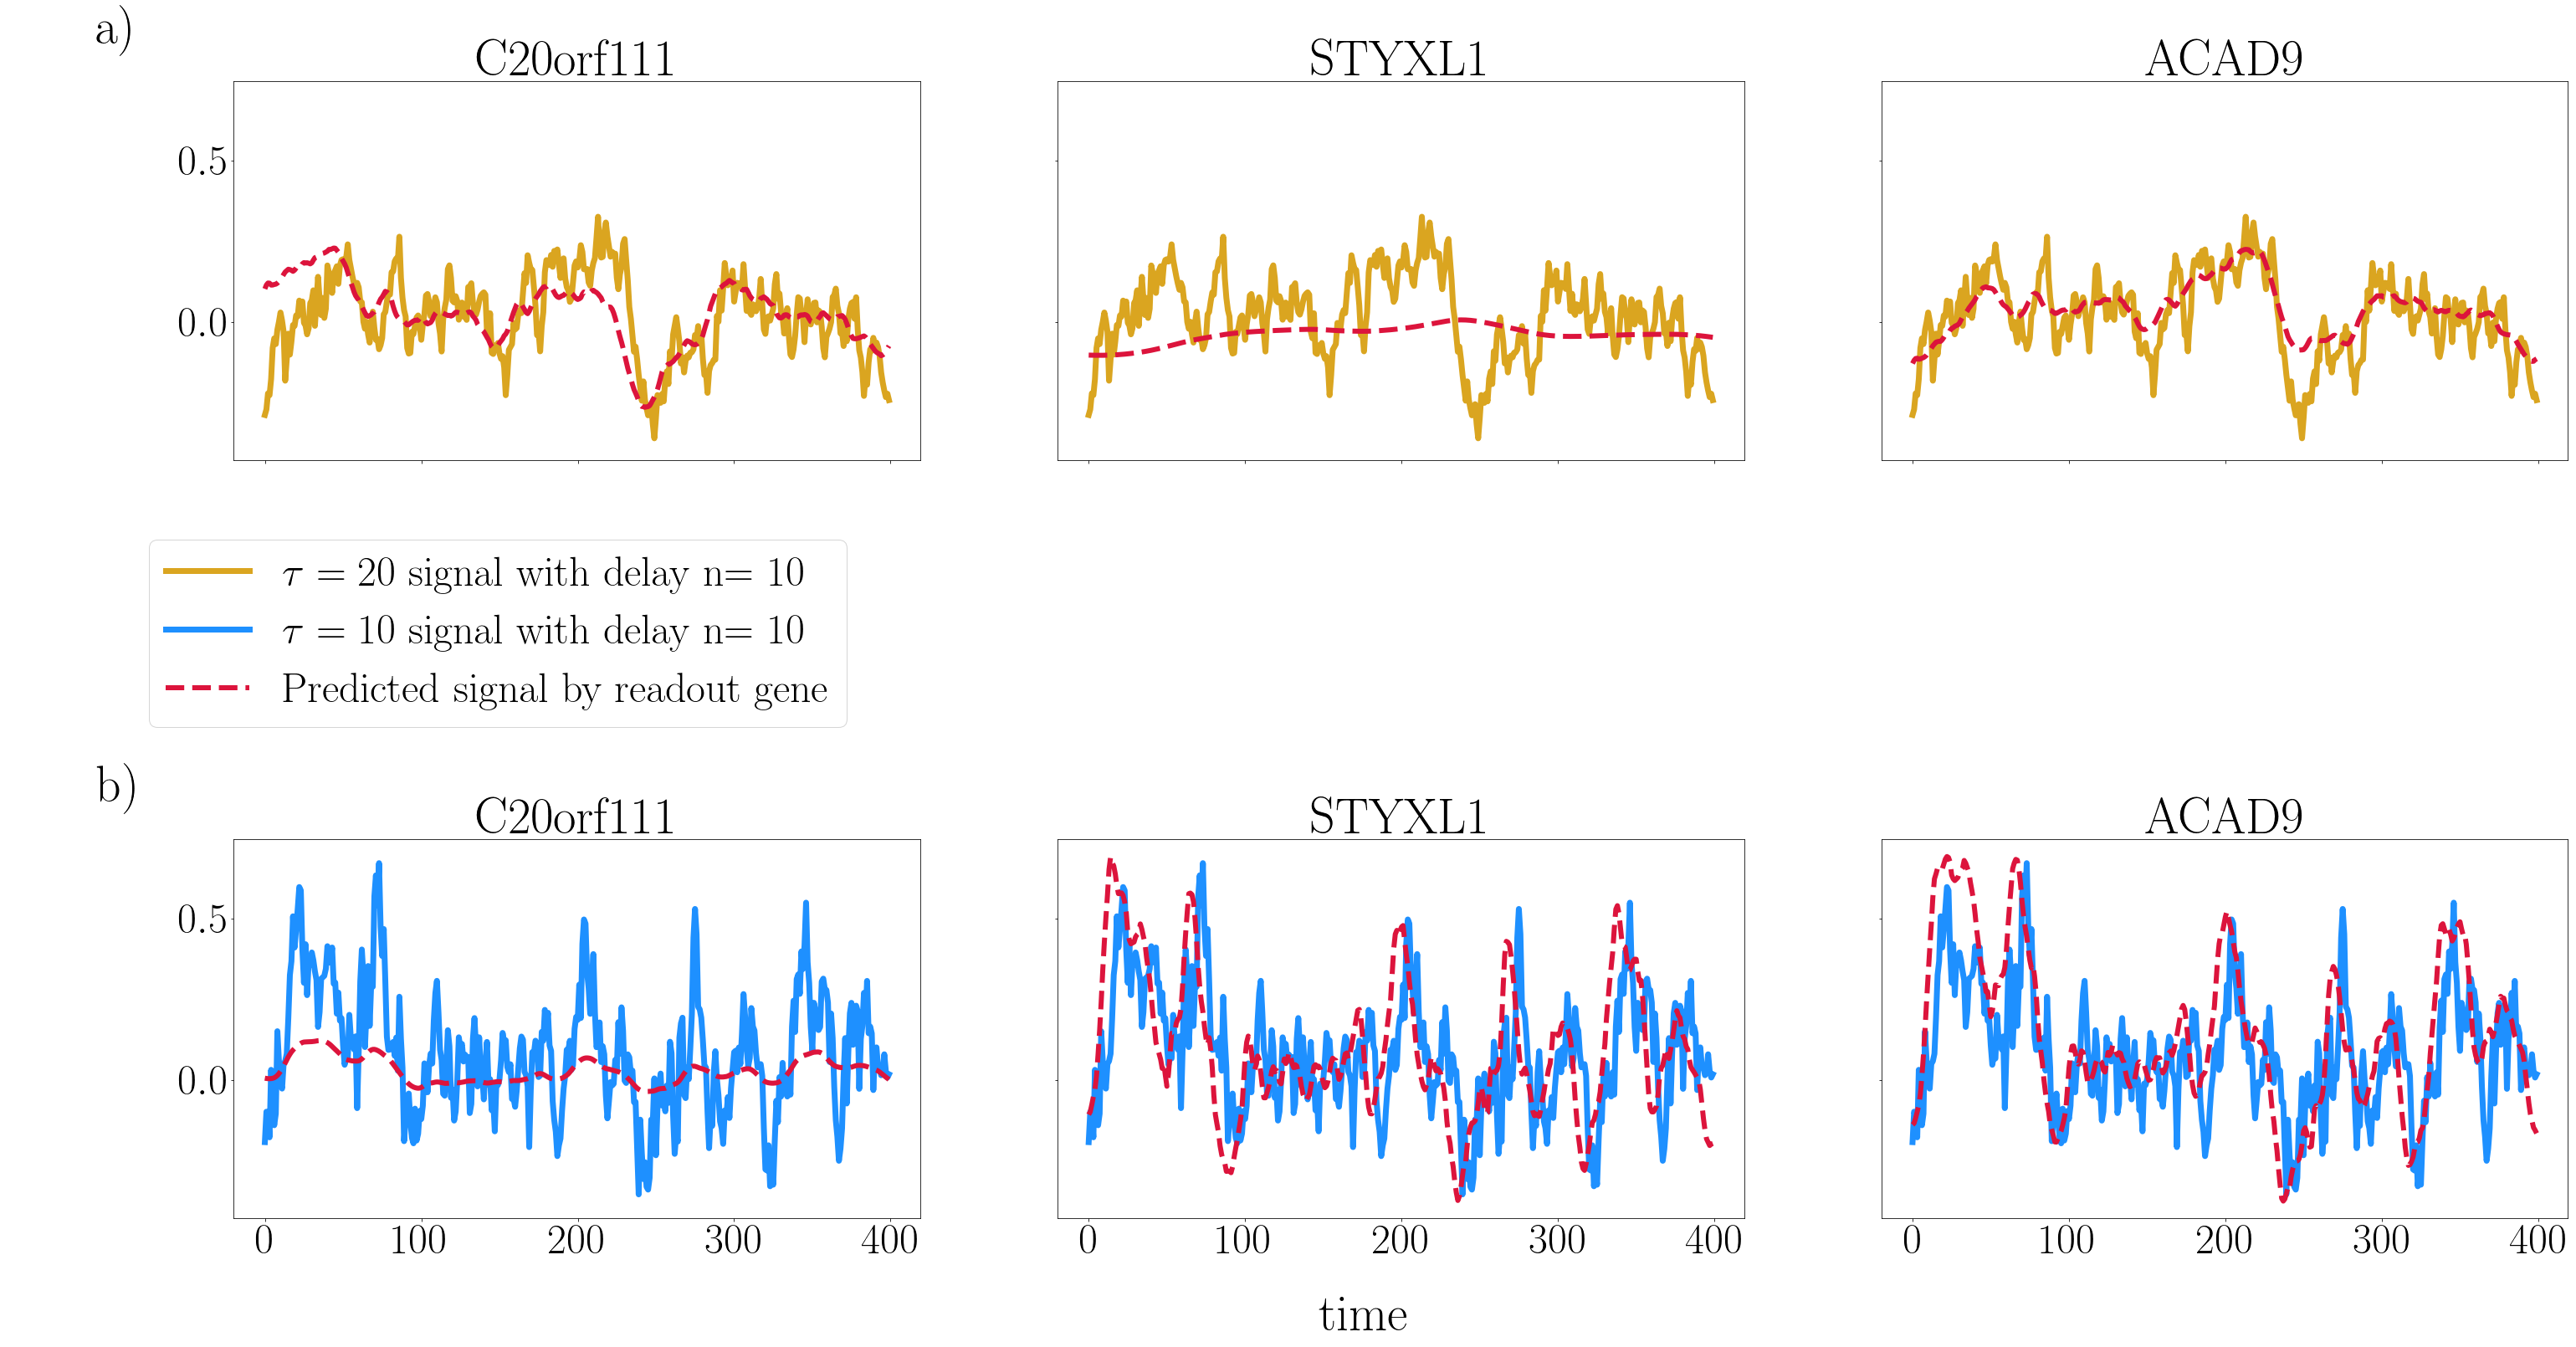

In [33]:
n=10

tau_net= {
    0:(20,"a)","goldenrod"),
    1:(10, "b)",'dodgerblue')
}
fig, axes = subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(50, 25))
fig.text(0.5, 0.05, 'time', ha='center',fontsize=60)
subplots_adjust(hspace=1)
for i,net in enumerate([net20,net10]):
    axes[i,0].text(-0.2, 1.1, tau_net[i][1], transform= axes[i,0].transAxes, size=60)       
    for j,readout_pos in enumerate([2,3,7]):
        ax1=axes[i,j]
        ax1.set_title(readout_name[readout_pos],fontsize=60)
        
        if i==0:
            h1=ax1.plot( net.u_dict[tau_net[i][0]][100+trainLen-n:trainLen+500-n], color=colors[tau_net[i][2]],linewidth=7 )
        else:
            h3=ax1.plot( net.u_dict[tau_net[i][0]][100+trainLen-n:trainLen+500-n], color=colors[tau_net[i][2]],linewidth=7 )
        h2=ax1.plot(net.Y[readout_pos,100:500],"--", color=colors['crimson'],linewidth=6 )
        #ax1.legend(['Noise signal with delay n= {}'.format(n), "Predicted signal"],fontsize=18)
        ax1.tick_params(axis='both', labelsize=50)
    #axes[i,0].legend(['Noise signal with delay n= {}'.format(n), "Predicted signal"],fontsize=50,bbox_to_anchor=(0.8,1.2))

figlegend([h1[0],h3[0],h2[0]],[r'$\tau=20$ signal with delay n= {}'.format(n), r'$\tau=10$ signal with delay n= {}'.format(n),"Predicted signal by readout gene"],fontsize=50,bbox_to_anchor=(0.288,0.55))    
show()

In [55]:
net.u_dict[20][trainLen-n:trainLen+100-n]

array([ 0.18912952,  0.13725546,  0.11629012,  0.11274432,  0.06665579,
        0.09229729,  0.0417662 , -0.00855451, -0.09733943, -0.15982328,
       -0.26281425, -0.38337283, -0.43625427, -0.44001615, -0.36969355,
       -0.28644203, -0.23718529, -0.18561258, -0.11951871, -0.1619107 ,
       -0.22088736, -0.21306545, -0.27298311, -0.23327595, -0.33224126,
       -0.27456585, -0.21977486, -0.21276534, -0.26211109, -0.30401452,
       -0.36149766, -0.3612596 , -0.30192382, -0.39066546, -0.38626795,
       -0.38651255, -0.3801002 , -0.41870697, -0.37373897, -0.39892633,
       -0.32619719, -0.32156786, -0.29855978, -0.2659175 , -0.24800731,
       -0.25920134, -0.29191153, -0.35382855, -0.28937098, -0.3136888 ,
       -0.30706879, -0.31600279, -0.25326414, -0.19134633, -0.16097324,
       -0.12776574, -0.10331672, -0.12210865, -0.1250273 , -0.19400058,
       -0.23143638, -0.18313277, -0.15476705, -0.13924972, -0.18546601,
       -0.26851781, -0.29388899, -0.3248758 , -0.29922531, -0.24

In [48]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20]
tau_train=20
 

network_edge_list_ENCODE.csv
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 30
GO:0070317 10
SR 0.95
Generating 30 noise
Generating 10 noise
Generating 40 noise
Autocorrelation of generated noise
30
[  1.31784728  51.40732624  -0.34026937]


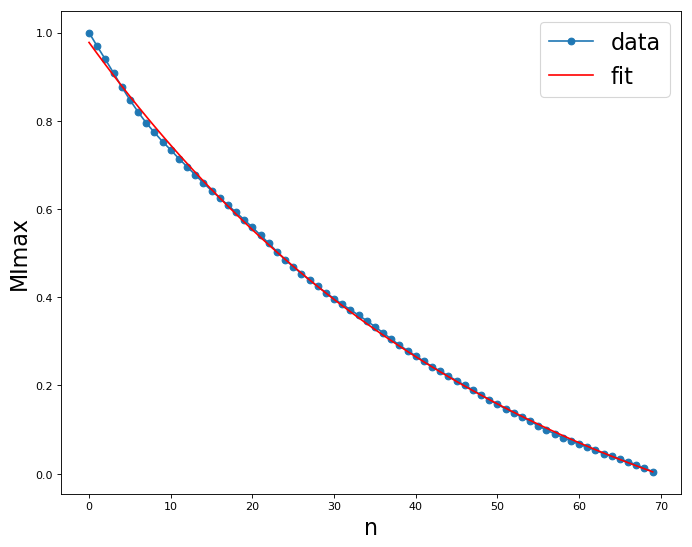

10
[ 1.08783125  9.94973113 -0.08106503]


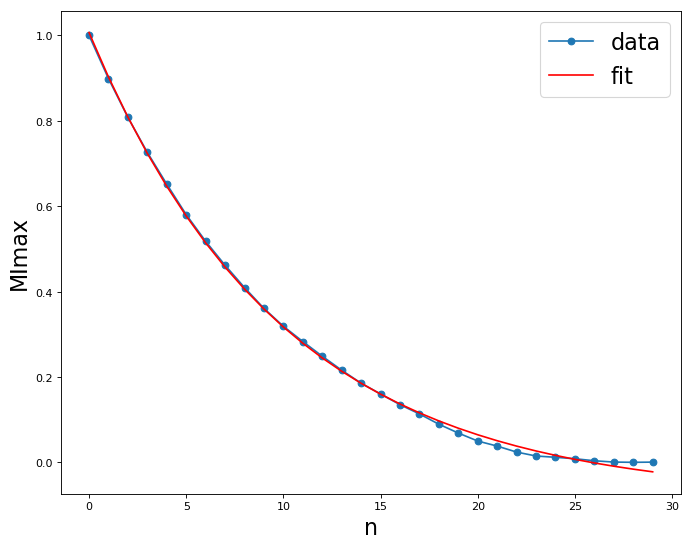

El traning se hace para 30 y en el testing introducimos las taus en 30
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 30
30 a la que se esta entrando
xact entreno 40
(5, 2800)
ZNF775 testing with neuron activation from tau_test= 30 (input tau 30)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 30
30 a la que se esta entrando
xact entreno 40
(5, 2800)
TMEM14C testing with neuron activation from tau_test= 30 (input tau 30)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 30
30 a la que se esta entrando
xact entreno 40
(5, 2800)
C20orf111 testing with neuron activation from tau_test= 30 (input tau 30)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 30
30 a la que se esta entrando
xact entreno 40
(5, 2800)
STYXL1 testing with neuron activation from tau_test= 30 (input tau 30)
BRD9 output being calcula

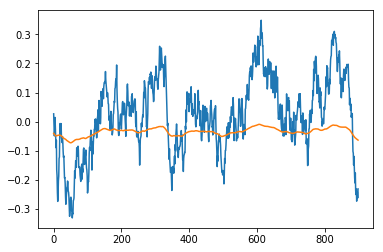

0.0716358995132
8.38103676219

El input al que comparamos es tau=10


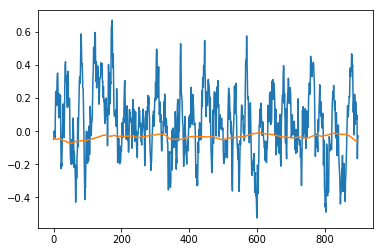

0.0109390365169
17.5372632156

TMEM14C
1
El input al que comparamos es tau=30


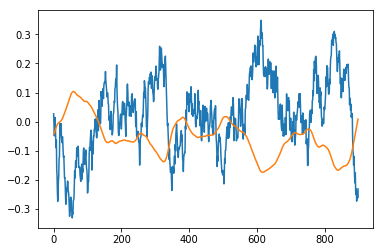

0.0451797298461
2.92339239478

El input al que comparamos es tau=10


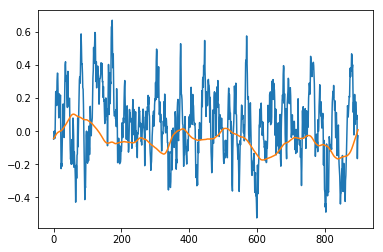

0.012285766317
4.02981559797

C20orf111
2
El input al que comparamos es tau=30


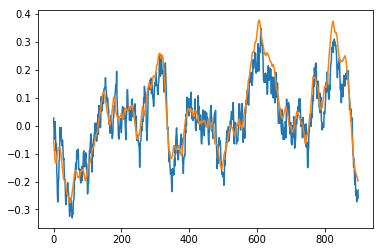

0.0689727051476
0.471287343344

El input al que comparamos es tau=10


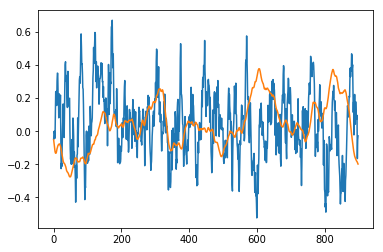

0.0113733713588
2.02302316

STYXL1
3
El input al que comparamos es tau=30


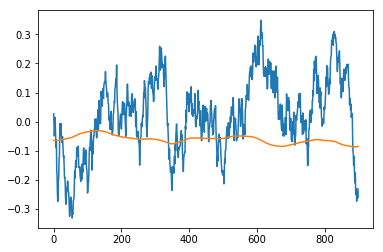

0.018882559058
10.8406885969

El input al que comparamos es tau=10


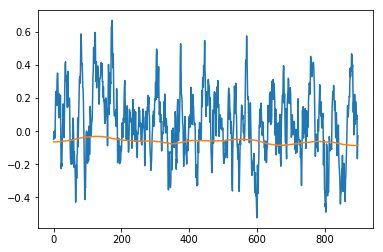

0.0144962904401
20.4911125192

BRD9
4
El input al que comparamos es tau=30


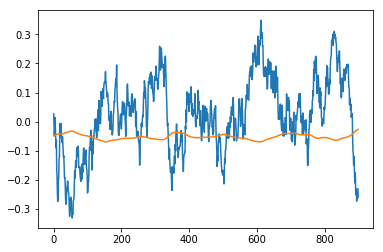

0.0394599376678
14.3342595143

El input al que comparamos es tau=10


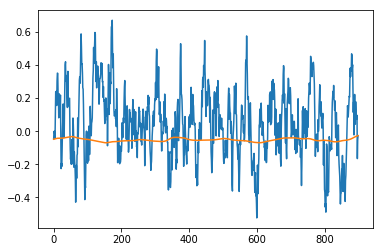

0.0083265510206
26.2563711283

ABCA3
5
El input al que comparamos es tau=30


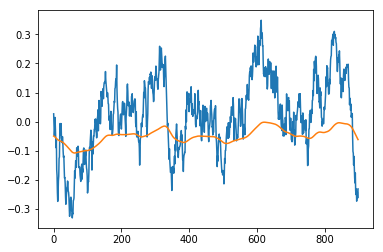

0.0402834776842
4.93554883029

El input al que comparamos es tau=10


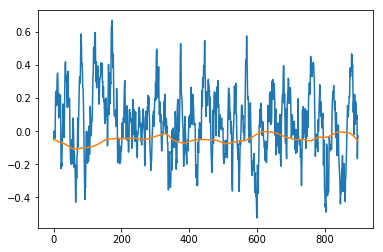

0.0126451941908
10.7430958995

ALDH1A1
6
El input al que comparamos es tau=30


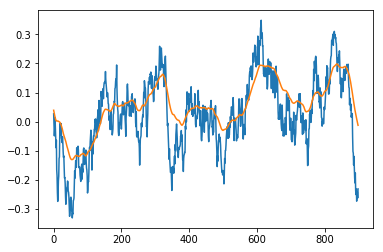

0.0462444464626
1.19802299672

El input al que comparamos es tau=10


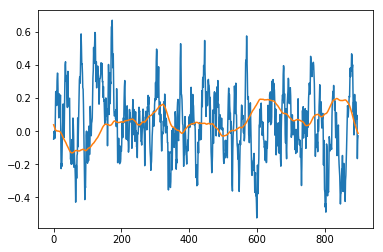

0.0123641537793
3.06787399894

ACAD9
7
El input al que comparamos es tau=30


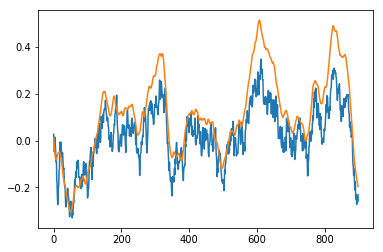

0.0708027112241
0.602380276945

El input al que comparamos es tau=10


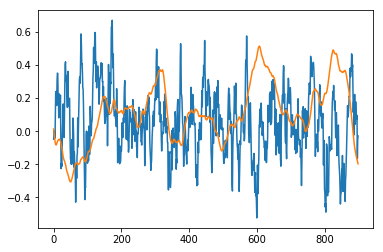

0.0123124917723
1.55782045309



In [49]:
net10=test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)


In [ ]:
## SIMULACION 2

In [74]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20,10,sum(tau_list)]
tau_train=10

network_edge_list_ENCODE.csv
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 20
GO:0070317 10
SR 0.95
Generating 20 noise
Generating 10 noise
Generating 30 noise
Autocorrelation of generated noise
20
[  1.03281951  29.62593263  -0.06836178]


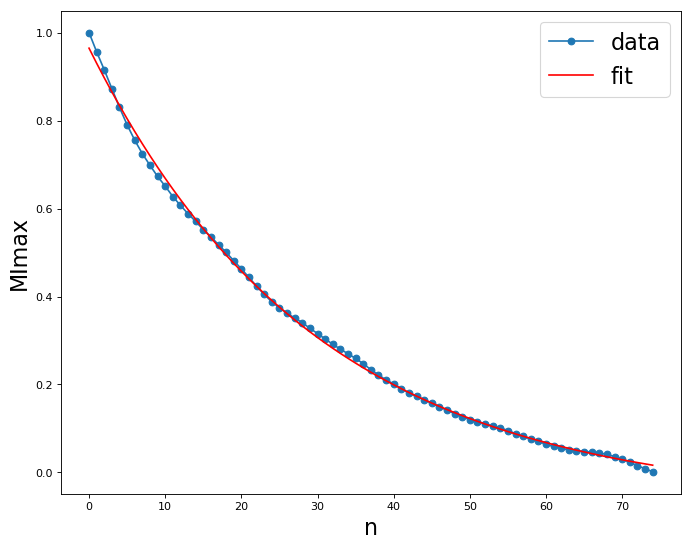

10
[ 1.01637122  8.71908207  0.01307606]


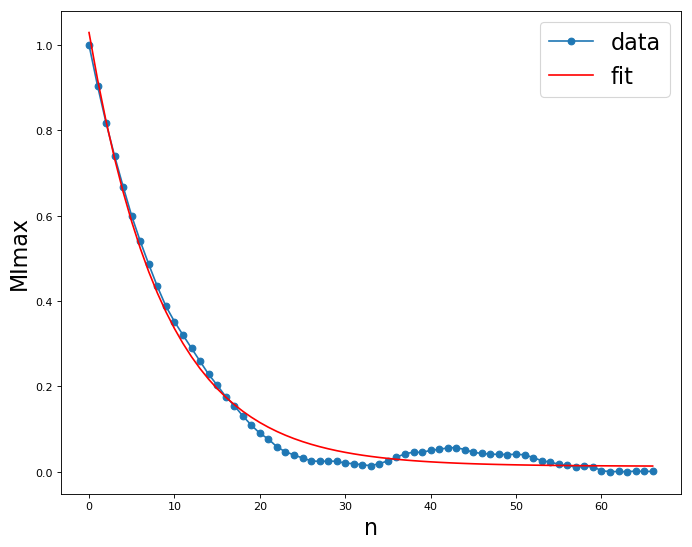

El traning se hace para 10 y en el testing introducimos las taus en 20
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 20 (input tau 20)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 20 (input tau 20)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 20 (input tau 20)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 20 (input tau 20)
BRD9 output being calcula

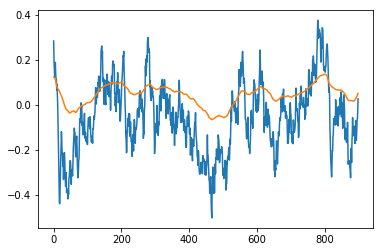

0.0916425763106
3.5097433037

El input al que comparamos es tau=10


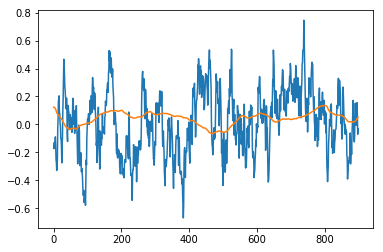

0.0306440453645
5.33315581828

TMEM14C
El input al que comparamos es tau=20


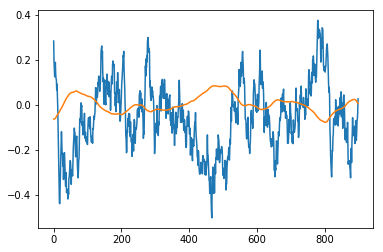

0.0653314801086
5.38542821335

El input al que comparamos es tau=10


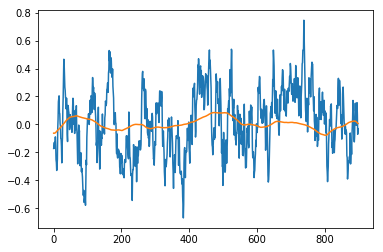

0.0304373633952
6.06275016729

C20orf111
El input al que comparamos es tau=20


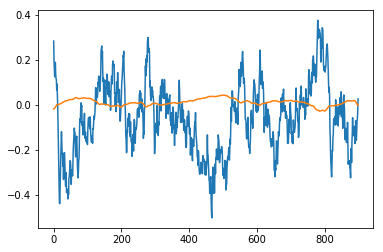

0.0723299319134
13.7336480962

El input al que comparamos es tau=10


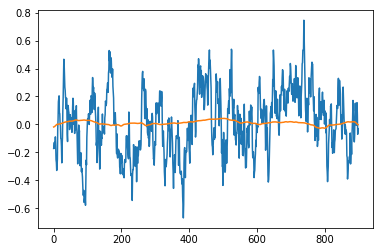

0.0244427645124
16.887874203

STYXL1
El input al que comparamos es tau=20


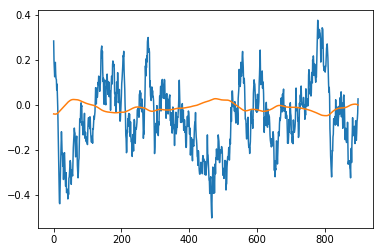

0.0660886556391
9.68765251967

El input al que comparamos es tau=10


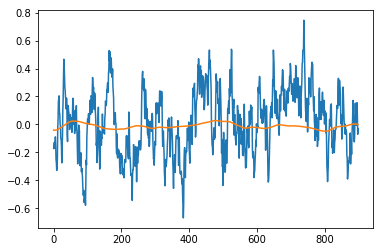

0.0253851429674
12.1878689379

BRD9
El input al que comparamos es tau=20


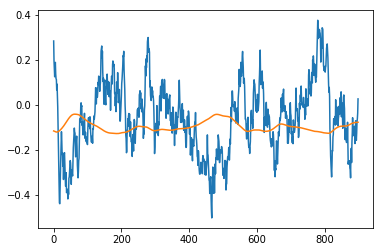

0.0505900462458
6.73466492798

El input al que comparamos es tau=10


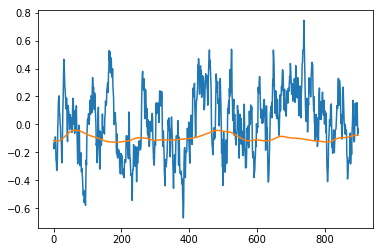

0.0325690536195
9.41328074578

ABCA3
El input al que comparamos es tau=20


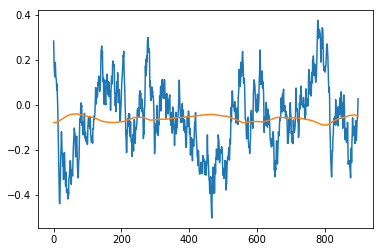

0.0687458244377
14.8347128256

El input al que comparamos es tau=10


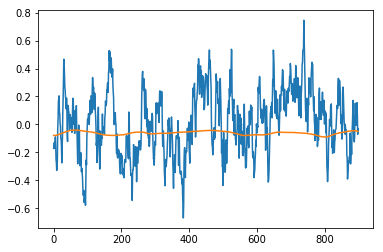

0.0250245363336
21.1476233037

ALDH1A1
El input al que comparamos es tau=20


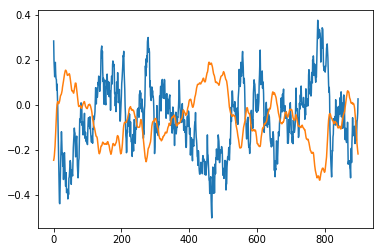

0.102588508111
2.35372392444

El input al que comparamos es tau=10


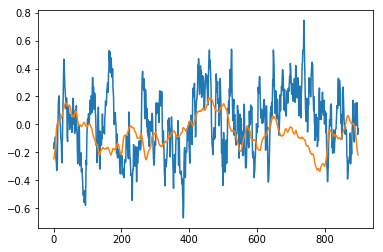

0.0226619920799
2.15797724636

ACAD9
El input al que comparamos es tau=20


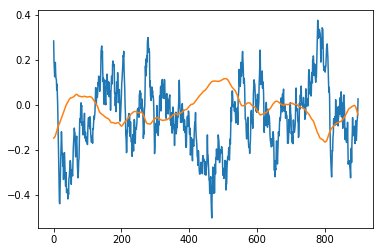

0.0619161227558
3.58087248894

El input al que comparamos es tau=10


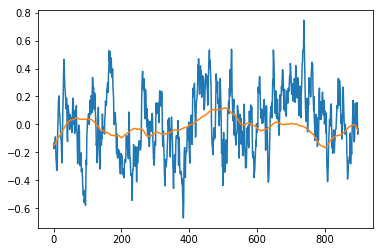

0.0275927023038
3.8547857771

El traning se hace para 10 y en el testing introducimos las taus en 10
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 10 (input tau 10)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 10 (input tau 10)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 10 (input tau 10)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 10 (input tau

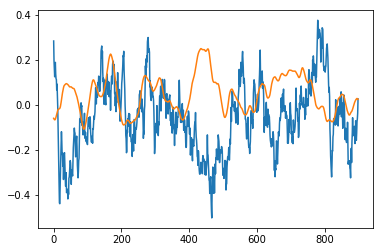

0.0328876251083
2.59148717331

El input al que comparamos es tau=10


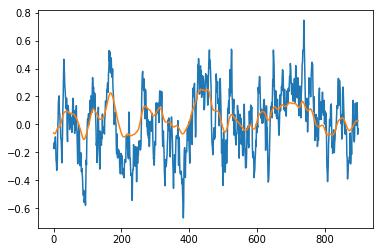

0.0700522099376
2.02464684019

TMEM14C
El input al que comparamos es tau=20


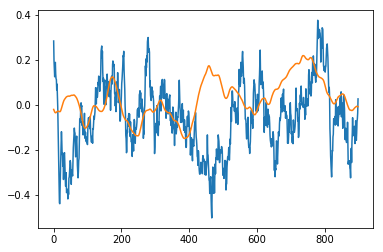

0.0358587574564
2.58366434967

El input al que comparamos es tau=10


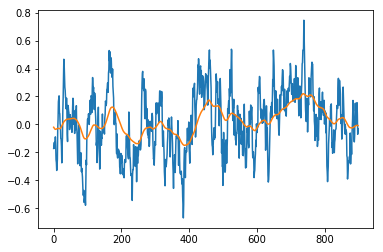

0.0491041482574
2.4536908394

C20orf111
El input al que comparamos es tau=20


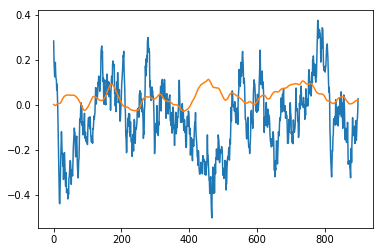

0.0327616832703
5.65750307733

El input al que comparamos es tau=10


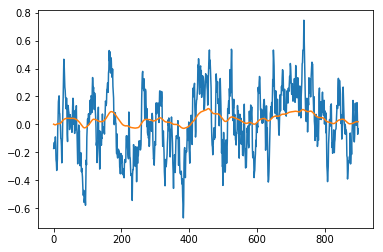

0.0663680884463
6.0855156812

STYXL1
El input al que comparamos es tau=20


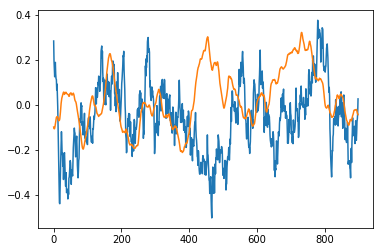

0.0325588008232
1.93988506139

El input al que comparamos es tau=10


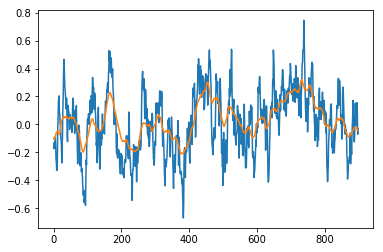

0.0722471755461
1.31812764303

BRD9
El input al que comparamos es tau=20


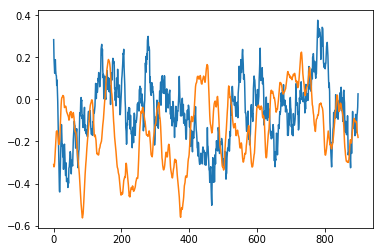

0.0260158311428
1.60159342035

El input al que comparamos es tau=10


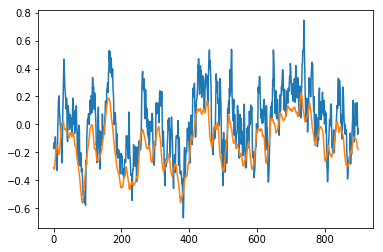

0.0706132322626
1.21233573594

ABCA3
El input al que comparamos es tau=20


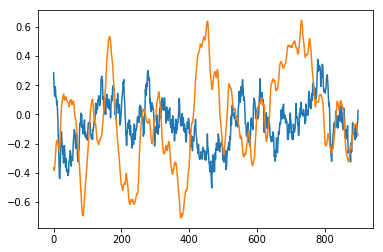

0.0283100317858
1.22329879962

El input al que comparamos es tau=10


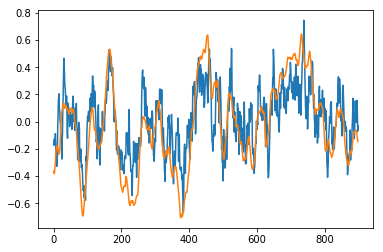

0.0777173740701
0.643226482375

ALDH1A1
El input al que comparamos es tau=20


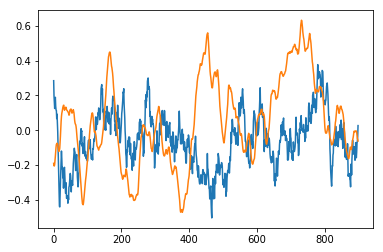

0.0307512531102
1.35907767565

El input al que comparamos es tau=10


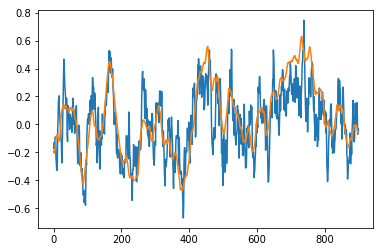

0.0735176534932
0.644096588723

ACAD9
El input al que comparamos es tau=20


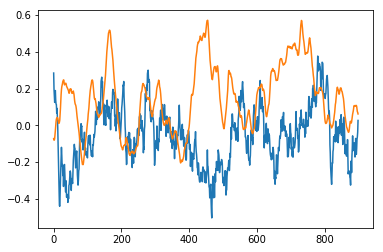

0.0357268024165
1.77862723597

El input al que comparamos es tau=10


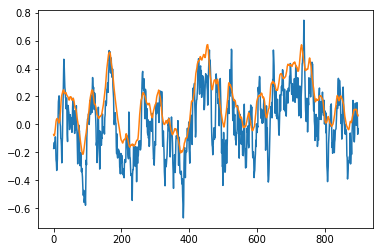

0.0780678550078
1.0082127858

El traning se hace para 10 y en el testing introducimos las taus en 30
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 30 (input tau 30)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 30 (input tau 30)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 30 (input tau 30)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 10
10 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 30 (input tau

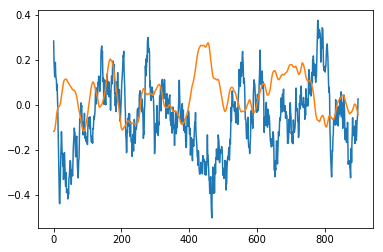

0.0398282215229
2.47088058444

El input al que comparamos es tau=10


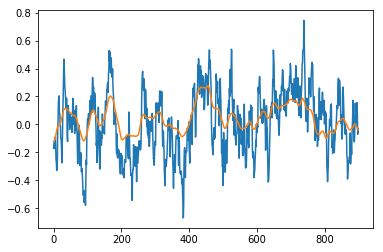

0.0683633572757
1.78912963337

TMEM14C
El input al que comparamos es tau=20


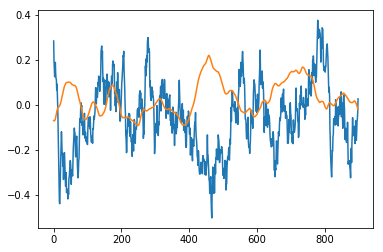

0.0386788623161
2.95046369092

El input al que comparamos es tau=10


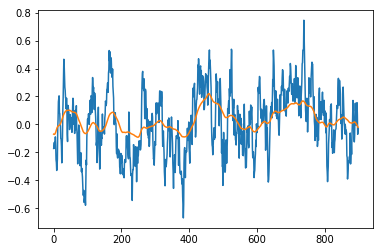

0.0552176405784
2.54009793759

C20orf111
El input al que comparamos es tau=20


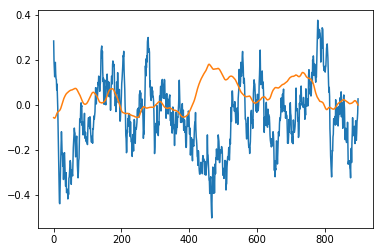

0.0351118391616
3.53338076368

El input al que comparamos es tau=10


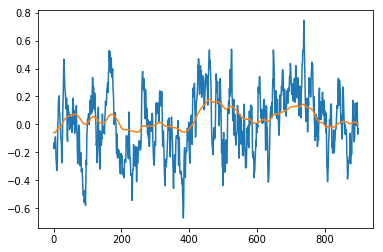

0.0456008436884
3.35579603895

STYXL1
El input al que comparamos es tau=20


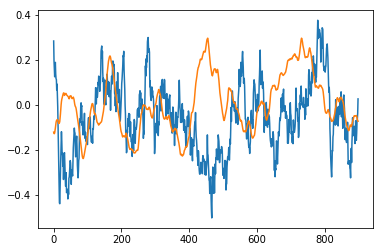

0.0318964235809
1.86642821169

El input al que comparamos es tau=10


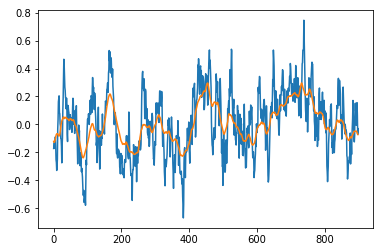

0.0707694568696
1.25801422409

BRD9
El input al que comparamos es tau=20


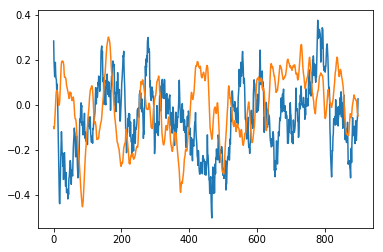

0.022646129405
1.51876397235

El input al que comparamos es tau=10


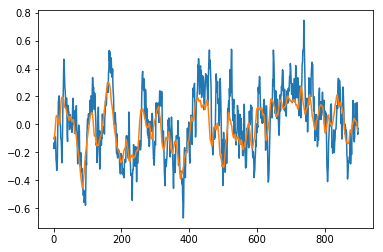

0.0569428806885
1.05768708763

ABCA3
El input al que comparamos es tau=20


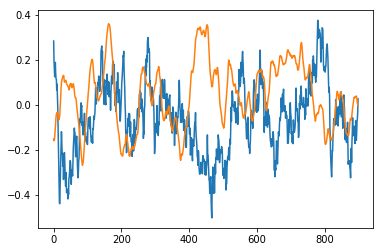

0.0283616187
1.71228663326

El input al que comparamos es tau=10


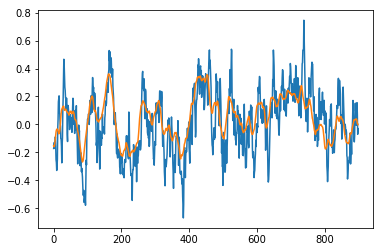

0.0705107951107
0.974790320881

ALDH1A1
El input al que comparamos es tau=20


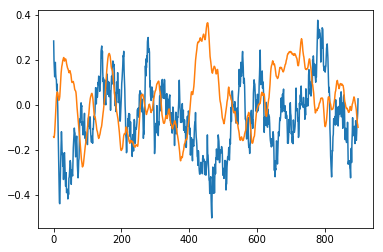

0.0336986306468
1.84312493435

El input al que comparamos es tau=10


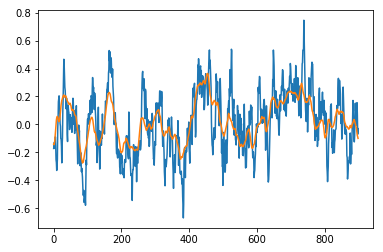

0.0651687235286
1.05588655333

ACAD9
El input al que comparamos es tau=20


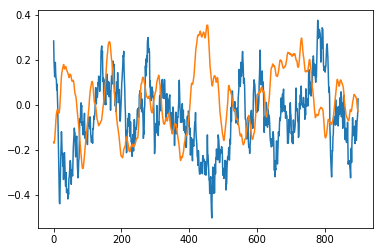

0.0315481144
1.75876235255

El input al que comparamos es tau=10


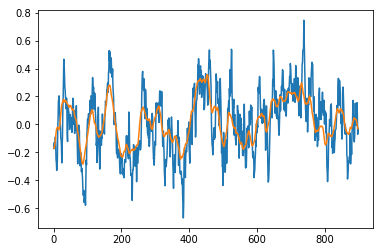

0.0724616866617
0.952308315034



In [75]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)

In [179]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20,10,sum(tau_list)]
tau_train=20

In [180]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,5, noise=True, euler=True, save=False, notebook=True)

network_edge_list_ENCODE.csv
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 20
GO:0070317 10
SR 0.95
Generating 20 noise


KeyboardInterrupt: 

In [78]:
i_scaling=[1,1]
beta_scaling=[0.05,0.05]
tau_list=[20,10]
tau_test=[20,10,sum(tau_list)]
tau_train=20

network_edge_list_ENCODE.csv
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 20
GO:0070317 10
SR 0.95
Generating 20 noise
Generating 10 noise
Generating 30 noise
Autocorrelation of generated noise
20
[  1.03281951  29.62593263  -0.06836178]


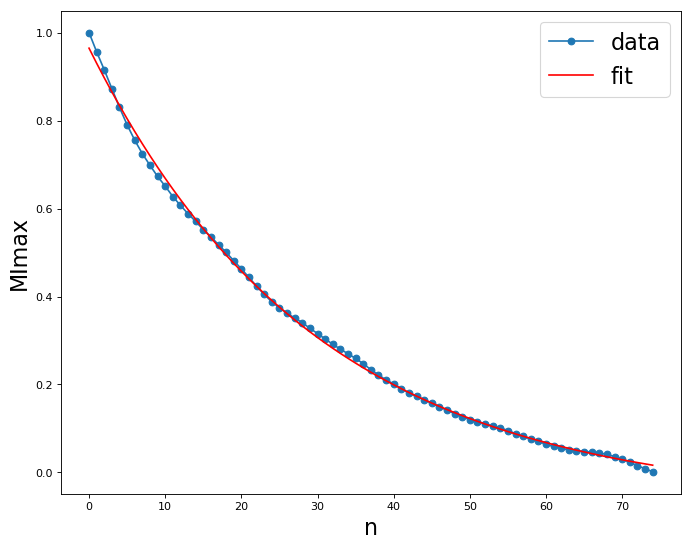

10
[ 1.01637122  8.71908207  0.01307606]


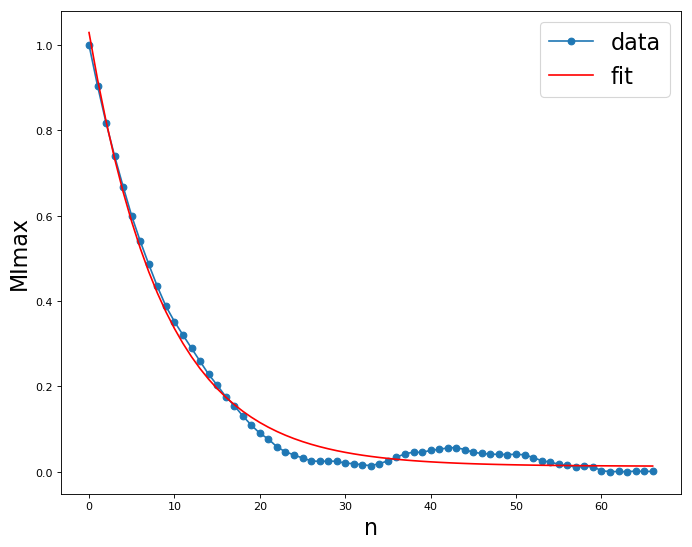

El traning se hace para 20 y en el testing introducimos las taus en 20
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 20 (input tau 20)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 20 (input tau 20)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 20 (input tau 20)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 20 (input tau 20)
BRD9 output being calcula

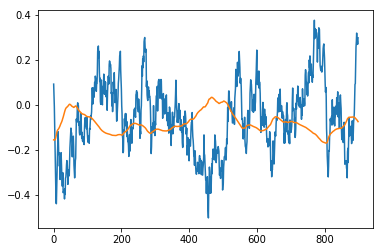

0.0538924337517
3.9145550948

El input al que comparamos es tau=10


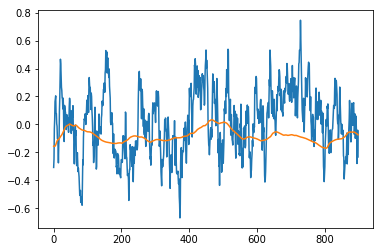

0.0266894294495
4.88958781134

TMEM14C
El input al que comparamos es tau=20


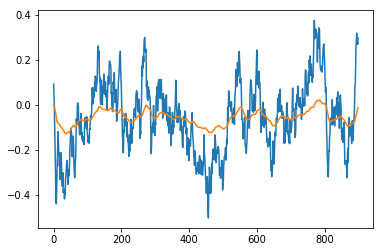

0.0942278869881
4.13164089598

El input al que comparamos es tau=10


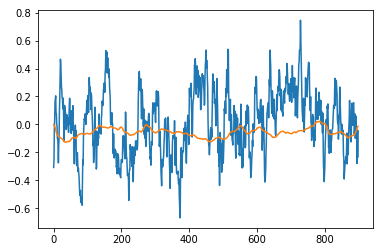

0.0233104787006
7.72065817494

C20orf111
El input al que comparamos es tau=20


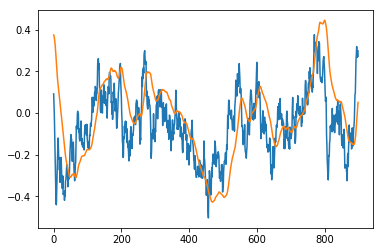

0.0512117207027
0.829617009166

El input al que comparamos es tau=10


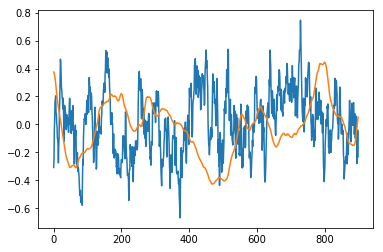

0.0208858787405
1.70317784813

STYXL1
El input al que comparamos es tau=20


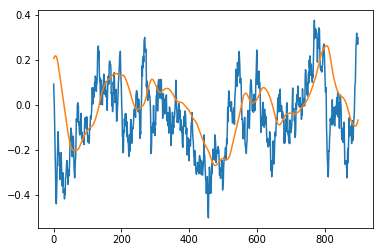

0.0373169359482
1.32090532272

El input al que comparamos es tau=10


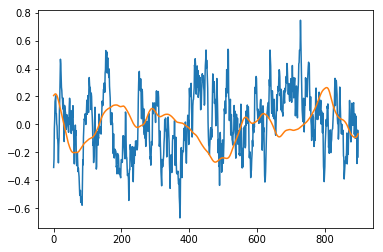

0.0238404052721
2.24648702963

BRD9
El input al que comparamos es tau=20


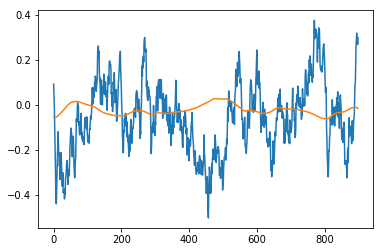

0.0416155949144
7.96135565576

El input al que comparamos es tau=10


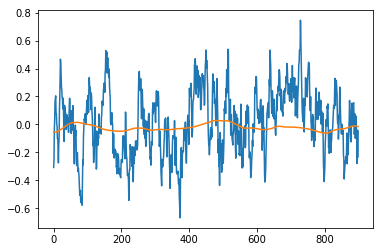

0.0253223295702
10.2636285303

ABCA3
El input al que comparamos es tau=20


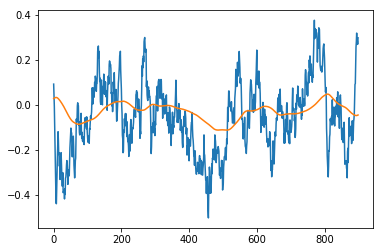

0.0318800399249
4.1388590491

El input al que comparamos es tau=10


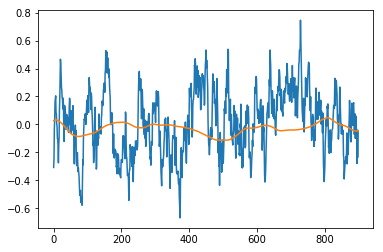

0.0286897818238
6.4192329056

ALDH1A1
El input al que comparamos es tau=20


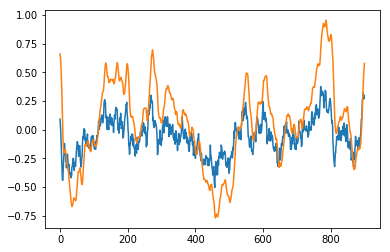

0.094077885701
0.716110456737

El input al que comparamos es tau=10


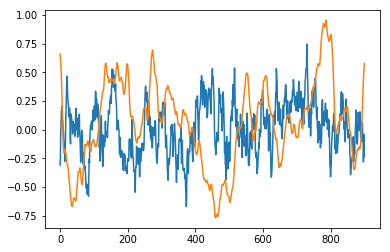

0.0224613663956
1.29328915947

ACAD9
El input al que comparamos es tau=20


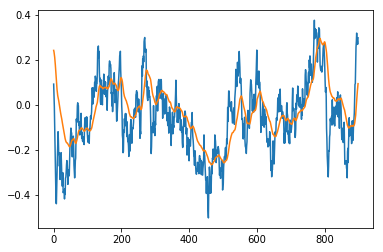

0.0627487710066
1.07355865139

El input al que comparamos es tau=10


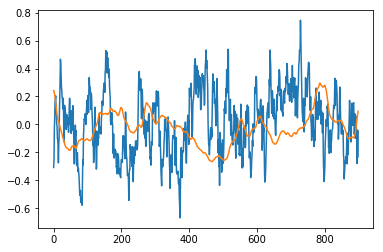

0.0251329816803
2.48035693229

El traning se hace para 20 y en el testing introducimos las taus en 10
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 10 (input tau 10)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 10 (input tau 10)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 10 (input tau 10)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 10 (input ta

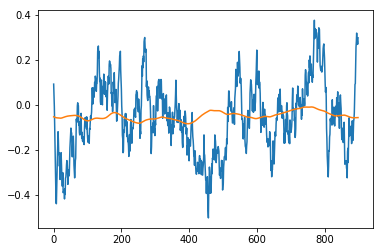

0.0368787344654
10.7217675407

El input al que comparamos es tau=10


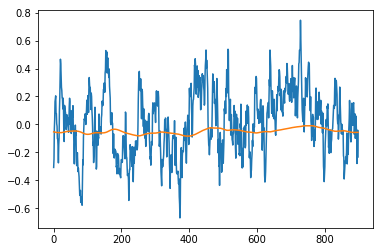

0.0228188208485
15.6449579971

TMEM14C
El input al que comparamos es tau=20


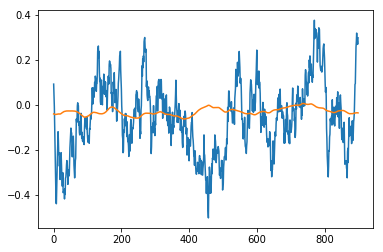

0.0405536850258
11.2714335849

El input al que comparamos es tau=10


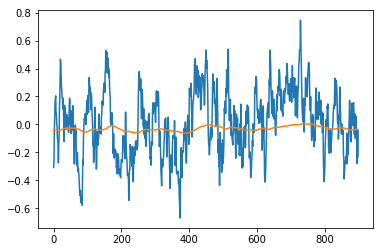

0.0291504962384
15.5760144855

C20orf111
El input al que comparamos es tau=20


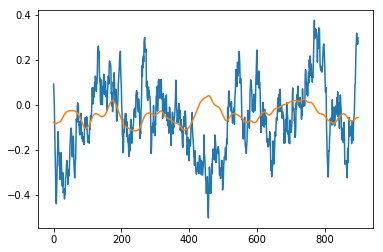

0.0374063128232
4.25448048556

El input al que comparamos es tau=10


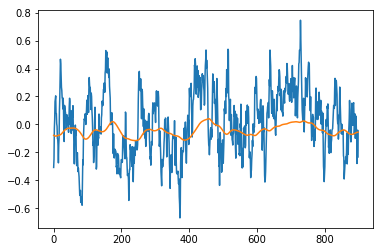

0.0277155384477
5.6919643319

STYXL1
El input al que comparamos es tau=20


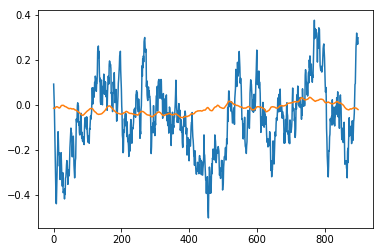

0.0478977227446
12.3162303323

El input al que comparamos es tau=10


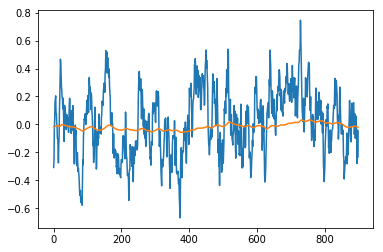

0.0293742557165
16.5362641124

BRD9
El input al que comparamos es tau=20


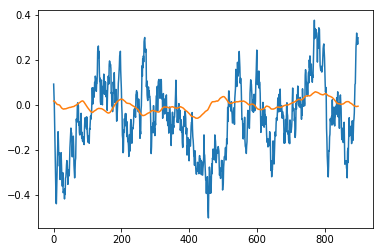

0.0437264784941
8.36022639703

El input al que comparamos es tau=10


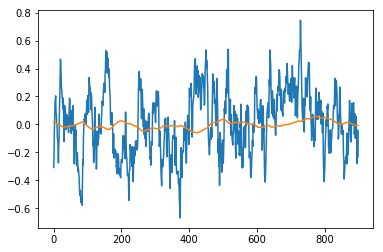

0.0237483236613
11.7048011956

ABCA3
El input al que comparamos es tau=20


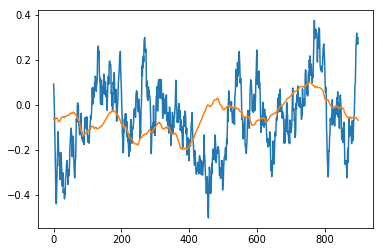

0.0433668815891
3.29265293707

El input al que comparamos es tau=10


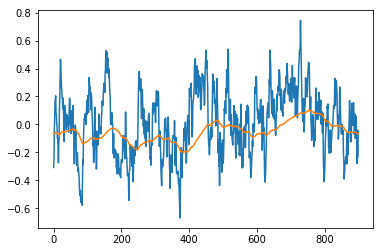

0.0247218608172
4.42737966239

ALDH1A1
El input al que comparamos es tau=20


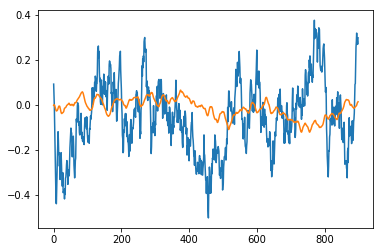

0.0347393236241
6.09333795966

El input al que comparamos es tau=10


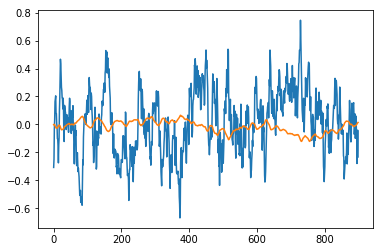

0.0393084909133
8.81121490697

ACAD9
El input al que comparamos es tau=20


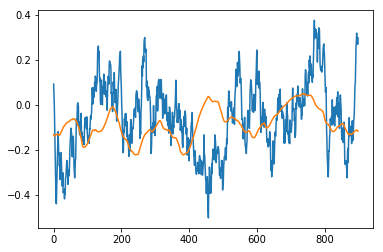

0.0377797327152
2.76807353501

El input al que comparamos es tau=10


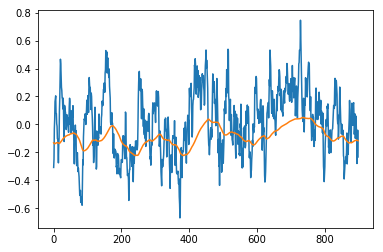

0.0304749422027
3.65131830111

El traning se hace para 20 y en el testing introducimos las taus en 30
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 30 (input tau 30)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 30 (input tau 30)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 30 (input tau 30)
STYXL1 output being calculated
STYXL1 training to noise and neuron activation with tau_train= 20
20 a la que se esta entrando
xact entreno 30
(5, 1800)
STYXL1 testing with neuron activation from tau_test= 30 (input ta

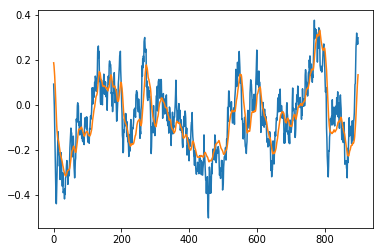

0.0914845038998
0.754262208852

El input al que comparamos es tau=10


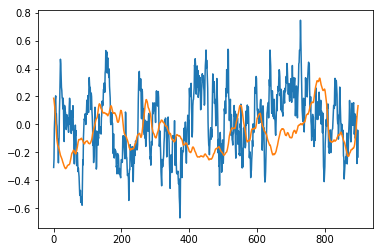

0.0247019764169
2.40584857427

TMEM14C
El input al que comparamos es tau=20


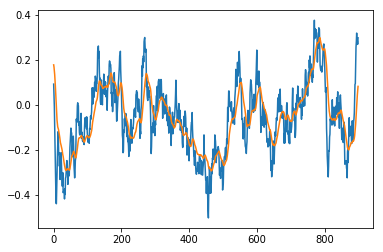

0.0836217450037
0.773601567054

El input al que comparamos es tau=10


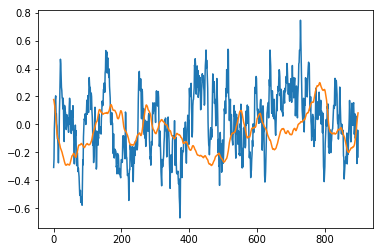

0.0253124725332
2.36507590655

C20orf111
El input al que comparamos es tau=20


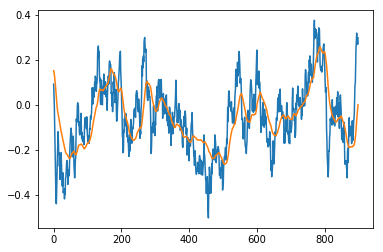

0.0594547281734
1.02273311687

El input al que comparamos es tau=10


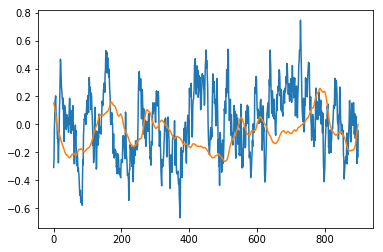

0.0213549061372
2.44892954615

STYXL1
El input al que comparamos es tau=20


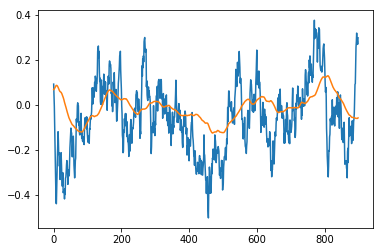

0.037056543798
2.94564268052

El input al que comparamos es tau=10


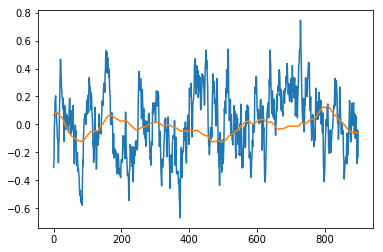

0.0231625199853
4.43890394351

BRD9
El input al que comparamos es tau=20


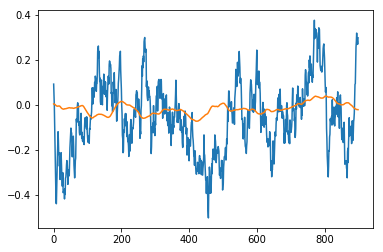

0.0453879288334
7.92942986675

El input al que comparamos es tau=10


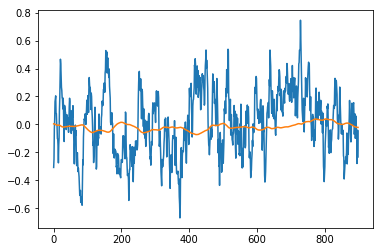

0.0273060456823
11.3974501649

ABCA3
El input al que comparamos es tau=20


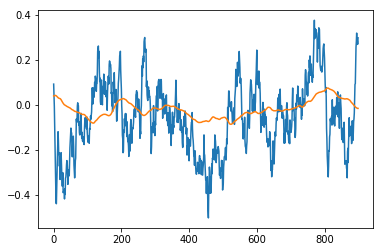

0.0483019526896
5.41047787254

El input al que comparamos es tau=10


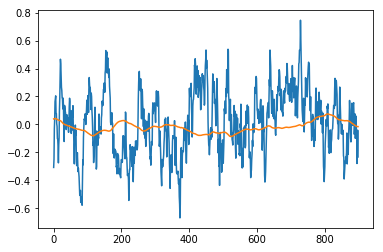

0.0232166001984
8.01960892333

ALDH1A1
El input al que comparamos es tau=20


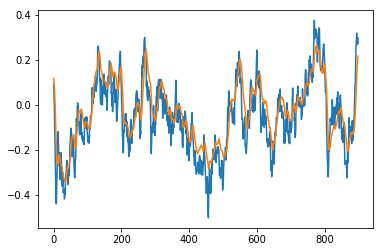

0.106452611742
0.58819146534

El input al que comparamos es tau=10


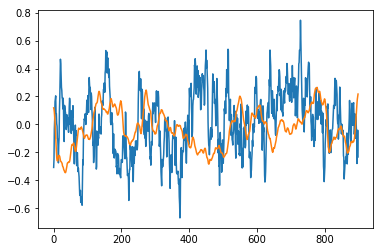

0.0231754091666
2.19533505879

ACAD9
El input al que comparamos es tau=20


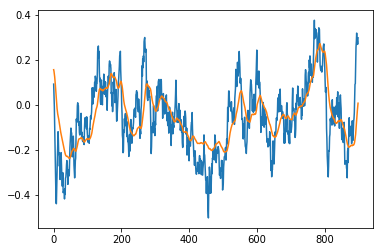

0.0673377980882
1.07618976382

El input al que comparamos es tau=10


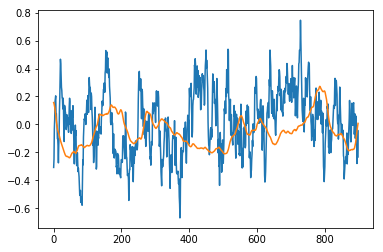

0.0224113688075
2.63113849237



In [79]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)

In [55]:
i_scaling=[1,0]
beta_scaling=[0.05,0.05]
tau_list=[1,5]
tau_test=[1,5,sum(tau_list)]
tau_train=6

In [77]:
test_readout("Dataset1",file, 1,tau_list,tau_test,tau_train, 0.95, i_scaling,beta_scaling,['GO:0051591','GO:0070317'],all_readout,10, noise=True, euler=True, save=False, notebook=True)

network_edge_list_ENCODE.csv
Running network...
seed puesta
factor i= [1, 1]
factor beta=[0.05, 0.05]
[1, 1]
GO:0051591 1
GO:0070317 5
SR 0.95
Generating 1 noise
Generating 5 noise
Generating 6 noise
Autocorrelation of generated noise
1
[ 1.00051683  1.12370209 -0.00402348]
5
[ 1.01445404  5.08477084 -0.01269242]
El traning se hace para 5 y en el testing introducimos las taus en 1
ZNF775 output being calculated
ZNF775 training to noise and neuron activation with tau_train= 5
5 a la que se esta entrando
(5, 1800)
ZNF775 testing with neuron activation from tau_test= 1 (input tau 1)
TMEM14C output being calculated
TMEM14C training to noise and neuron activation with tau_train= 5
5 a la que se esta entrando
(5, 1800)
TMEM14C testing with neuron activation from tau_test= 1 (input tau 1)
C20orf111 output being calculated
C20orf111 training to noise and neuron activation with tau_train= 5
5 a la que se esta entrando
(5, 1800)
C20orf111 testing with neuron activation from tau_test= 1 (input ta

In [42]:
## SIMULACIONES CON UN INPUT

In [43]:
i_scaling=[0,1]

In [44]:
test("Dataset1",file, 2, 1,i_scaling,beta_scaling,['GO:0070317', 'GO:0051591'],0, noise=True)

network_edge_list_ENCODE.csv
Running network...


TypeError: initialize() missing 1 required positional argument: 'tau_list'

In [ ]:
#Save dictionary
i_scaling=0.05
beta_scaling=0.05
MI_GOterm={}
for GOterm in GO_id_map.keys():
    print(GOterm)
    mi_go_by_gene,mi_not_go=test("Dataset1",file, "noise", 1,i_scaling,beta_scaling,GOterm,0, noise=True)
    MI_GOterm[GOterm]={
        "mi_go":mi_go_by_gene,
        "mi_not_go":mi_not_go
    }

In [ ]:
beta_scaling=1
for i_scaling in [100,0,1,0.05]:
    mi_go_by_gene,mi_not_go=test("Dataset1",file, "noise", 1,i_scaling,beta_scaling,"GO:0006337",0, noise=True)
    mi_mean=np.mean(list(mi_go_by_gene.values()))
    print("Mean MI Genes with GOterm: {:.3}".format(mi_mean))
    not_mi_mean=np.mean(mi_not_go)
    print("Mean MI Genes without GOterm:{:.3}".format(not_mi_mean))
    for el in sorted(mi_go_by_gene, key=mi_go_by_gene.get, reverse=True):
        print("{0:>15} {1:>5} {2:>5} {3:>5}  {4:{width}{numbers}}\n".format(el[0],el[1],G.in_degree(el[0]),G.out_degree(el[0]), mi_go_by_gene[el],width=5,numbers=".2"))

In [ ]:
import pandas
pandas.Series(np.array([0,1,2,2])).value_counts()

In [ ]:
i_scaling=0.05
mi_go_by_gene,mi_not_go=test("Dataset1",file, "noise", 1,i_scaling,beta_scaling,"GO:0006337",0, noise=True)

In [ ]:
##TABLA CON DEGREES
width=8
out_file=open("go_mi.txt","w")
for key in MI_GOterm.keys():
    out_file.write(key+"\n")
    for el in sorted(MI_GOterm[key]["mi_go"], key=MI_GOterm[key]["mi_go"].get, reverse=True):
        out_file.write("{0:>15} {1:>5} {2:>5} {3:>5}{4:{width}{numbers}}\n".format(el[0],el[1],G.in_degree(el[0]),G.out_degree(el[0]), MI_GOterm[key]["mi_go"][el],width=width,numbers=".2"))

In [ ]:
dictionary = {'hello':'world'}
np.save('mi_i_scaling{}.npy'.format(i_scaling), MI_GOterm) 


In [ ]:
MI_GOterm_from_file=MI_GOterm

In [ ]:
# Load
MI_GOterm_from_file = np.load('mi_i_scaling{}.npy').item()

In [ ]:
## TABLA CON MEDIAS
for key in MI_GOterm_from_file.keys():
    
    mi_mean=np.mean(list(MI_GOterm_from_file[key]["mi_go"].values()))
    #print("Mean MI Genes with GOterm: {:.3}".format(mi_mean))
    not_mi_mean=np.mean(MI_GOterm_from_file[key]["mi_not_go"])
    #print("Mean MI Genes without GOterm:{:.3}".format(not_mi_mean))
    print("{0:>5}{1:{width}{numbers}}{2:{width}{numbers}}".format(key,mi_mean, not_mi_mean,width=15, numbers=".2"))

In [ ]:
indexes=list(range(0,2))+[index+2+1 for index in range(0,5)]
indexes